In[9]:

In [4]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.color import rgba2rgb
import pickle
import time
from flask import Flask, jsonify
import threading
import matplotlib.pyplot as plt
import seaborn as sns

In[10]:

In [6]:
app = Flask(__name__)
start_time=time.time()

In [7]:
input_dir = r"E:\Education\Projects\Machine Learning\Computer Vision\Malicious-Sign-Detection\carla_lights\traffic_light_data"
categories = ['green', 'red', 'yellow', "unknown"]
blurred_suffix = ' blurred'  
img_size = (15, 15)  

In [8]:
data_train = []
labels_train = []
data_val = []
labels_val = []

In[11]:

In [10]:
def load_images(category, folder_type, data, labels):
    
    category_path = os.path.join(input_dir, folder_type, category)
    blurred_path = os.path.join(input_dir, folder_type, f"{category}{blurred_suffix}")
    for folder in [category_path, blurred_path]:
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            try:
                img = imread(img_path)
                #Converting RGBA to RGB if necessary
                if img.shape[-1] == 4:  # If image has 4 channels (RGBA)
                    img = rgba2rgb(img)
                img = resize(img, img_size)
                if img.shape == (15, 15, 3):  
                    data.append(img.flatten())
                    labels.append(category)
                else:
                    print(f"Skipping {file}: Invalid shape after resize {img.shape}")
            except Exception as e:
                print(f"Error loading {file}: {e}")

In [11]:
for category in categories:
    load_images(category, 'train', data_train, labels_train)

In [12]:
for category in categories:
    load_images(category, 'val', data_val, labels_val)

In [13]:
x_train = np.array(data_train)
y_train = np.array(labels_train)
x_val = np.array(data_val)
y_val = np.array(labels_val)

In [14]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

x_train shape: (4100, 675), y_train shape: (4100,)
x_val shape: (1402, 675), y_val shape: (1402,)


In[12]:

 training SVC model with hyperparameter tuning

In [17]:
classifier = SVC(probability=True)
parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
#parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

In [18]:
grid_search = GridSearchCV(classifier, parameters, cv=3)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}])

In [19]:
best_estimator = grid_search.best_estimator_

 Evaluation

In [21]:
y_pred = best_estimator.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 95.15%


 Classification report

In [23]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       green       0.98      0.81      0.89       200
         red       0.99      0.89      0.94       212
     unknown       0.93      1.00      0.96       823
      yellow       0.98      0.96      0.97       167

    accuracy                           0.95      1402
   macro avg       0.97      0.92      0.94      1402
weighted avg       0.95      0.95      0.95      1402



127.0.0.1 - - [04/Dec/2024 12:15:20] "GET /data HTTP/1.1" 200 -


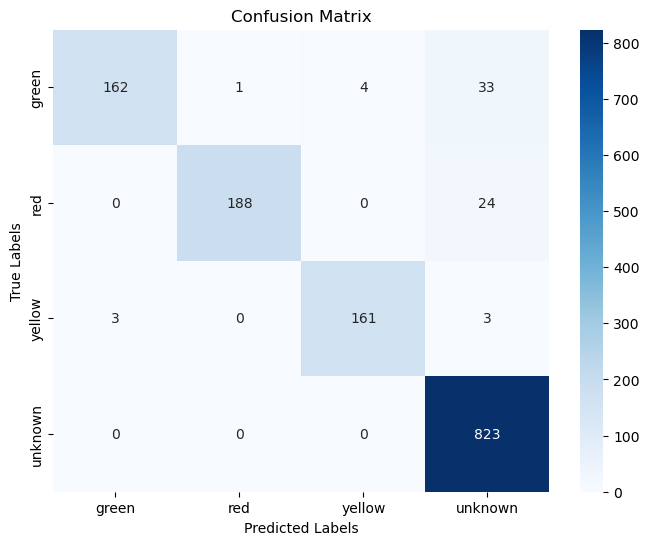

In [75]:
# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred, labels=categories)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In[13]:

In [25]:
def classify_image_with_unknown(image_path, model, threshold=0.7):
   
    img = imread(image_path)
    ##RGB conversion
    if img.shape[-1] == 4:  
        img = rgba2rgb(img)
    img = resize(img, img_size).flatten()
    img = img.reshape(1, -1)  

    ## Prediction
    probabilities = model.predict_proba(img)
    max_confidence = np.max(probabilities)
    predicted_class = model.predict(img)[0]
    if max_confidence < threshold:
        return "unknown"
    return predicted_class

In[14]:

In [27]:
model_file_name = r"E:\Education\Projects\Machine Learning\Computer Vision\Malicious-Sign-Detection\classifier"  # Specify the filename
with open(model_file_name, 'wb') as file:
    pickle.dump(best_estimator, file)

In [28]:
print(f"Model saved as {model_file_name}")

Model saved as E:\Education\Projects\Machine Learning\Computer Vision\Malicious-Sign-Detection\classifier


In[16]:

Path to the test image

In [31]:
test_image_path = r"E:\Education\Projects\Machine Learning\Computer Vision\Malicious-Sign-Detection\carla_lights\traffic_light_data\test"

Check if directory exists

In [33]:
if not os.path.exists(test_image_path):
    print(f"Error: The directory '{test_images_dir}' does not exist.")
    exit()

Iterate through test images and classify them

In [35]:
test_results = {}

In [73]:
for file in os.listdir(test_image_path):
    image_path = os.path.join(test_image_path, file)
    if os.path.isfile(image_path) and file.endswith(('.png', '.jpg', '.jpeg')):
        # Classify the image
        result = classify_image_with_unknown(image_path, best_estimator, threshold=0.5)
        test_results[file] = result
        print(f"Image: {file}, Classification Result: {result}")
    else:
        print(f"Skipping {file}: Not a valid image file.")

Image: traffic_light_frame1044.png, Classification Result: unknown
Image: traffic_light_frame116.png, Classification Result: unknown
Image: traffic_light_frame120.png, Classification Result: red
Image: traffic_light_frame1421.png, Classification Result: unknown
Image: traffic_light_frame144.png, Classification Result: red
Image: traffic_light_frame145.png, Classification Result: unknown
Image: traffic_light_frame1450.png, Classification Result: unknown
Image: traffic_light_frame1479.png, Classification Result: unknown
Image: traffic_light_frame1508.png, Classification Result: yellow
Image: traffic_light_frame1566.png, Classification Result: unknown
Image: traffic_light_frame1595.png, Classification Result: unknown
Image: traffic_light_frame1624.png, Classification Result: unknown
Image: traffic_light_frame1653.png, Classification Result: green
Image: traffic_light_frame1682.png, Classification Result: unknown
Image: traffic_light_frame1711.png, Classification Result: unknown
Image: tra

In [37]:
end_time = time.time()

etrics to be streamed

In [39]:
execution_time = end_time - start_time
report = classification_report(y_val, y_pred, output_dict=True)
precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_score_macro = report['macro avg']['f1-score']
support_macro = report['macro avg']['support']

In [40]:
metrics = {
    "Classification_Result": result,
    "Validation_Accuracy": accuracy,
    "Execution_Time": execution_time,
    "Macro_Precision": precision_macro,
    "Macro_Recall": recall_macro,
    "Macro_F1_score": f1_score_macro,
    "Macro_Support": support_macro,
    "Test_Results" : test_results
}

In [41]:
def run_flask():
    app.run(debug=False, port=5000)

In [42]:
@app.route('/data', methods=['GET'])
def get_data():
    return jsonify(metrics), 200

In [43]:
if __name__ == '__main__':
    threading.Thread(target=run_flask, daemon=True).start()

In[ ]:

In[ ]: